# SysArmy - Análisis de encuesta 2020.02 - COVID

## 1. Carga y sanitización de datos

###  1.1. Definimos los metadatos asociados al dataset que vamos a analizar

In [1]:
csv_url = "https://raw.githubusercontent.com/openqube/openqube-sueldos/master/data/csv/argentina/2020.02.csv"

dataset_metadata = {"year": 2020,
                    "part": 2,
                    "skiprows": 0,
                    "publish_date": "2020-08-15",
                    "minimum_salary": 16875} # https://es.wikipedia.org/wiki/Anexo:Salario_m%C3%ADnimo_en_Argentina

### 1.2. En base a los metadatos, cargamos el CSV, limpiamos columnas y las transformamos

In [2]:
import pandas as pd
import io
import requests
from time import sleep
import matplotlib.pyplot as plt

raw_dataframe = None
source = requests.get(csv_url).content
raw_dataframe = pd.read_csv(io.StringIO(source.decode("utf-8")),
                            skiprows=dataset_metadata["skiprows"],
                            thousands=".",
                            decimal=",")

import re

regex_white_chars = re.compile(r"\s+")
regex_non_alphanum = re.compile(r"\W+_?", re.I)

raw_dataframe.columns = (raw_dataframe.columns.str.strip()
                         .str.lower()
                         .str.replace(regex_white_chars, "_")
                         .str.replace(regex_non_alphanum, "")
                         .str.translate("ñáéíóú".maketrans({"ñ": "n", "á": "a", "é": "e", "í": "i", "ó": "o", "ú": "u"})))

# Eliminamos los datos que no pertenezcan a Argentina
raw_dataframe = raw_dataframe[raw_dataframe["estoy_trabajando_en"] == "Argentina"]

# Conservamos únicamente las columnas relacionadas con COVID-19
columns_to_keep = ["timestamp",
                   "me_identifico",
                   "donde_estas_trabajando",
                   "trabajo_de",
                   "tipo_de_contrato",
                   "salario_mensual_bruto_en_tu_moneda_local",
                   "como_venis_llevando_la_cuarentena",
                   "tenes_hijosas_menores_de_edad",
                   "con_cuantas_personas_estas_conviviendo",
                   "con_quienes_convivis",
                   "tenes_un_espacio_dedicado_para_el_trabajo",
                   "tenes_que_compartir_tu_equipo_de_trabajo_con_alguien",
                   "que_tipo_de_cuarentena_estas_haciendo",
                   "cambio_tu_situacion_laboral_a_raiz_de_la_pandemia",
                   "que_tanto_sentis_que_te_esta_apoyando_tu_empresa_en_esta_situacion",
                   "como_se_vio_afectada_tu_empresa",
                   "instauraron_algun_beneficio_nuevo"]

raw_dataframe = raw_dataframe[columns_to_keep]


df = raw_dataframe.copy()
df.head()

,timestamp,me_identifico,donde_estas_trabajando,trabajo_de,tipo_de_contrato,salario_mensual_bruto_en_tu_moneda_local,como_venis_llevando_la_cuarentena,tenes_hijosas_menores_de_edad,con_cuantas_personas_estas_conviviendo,con_quienes_convivis,tenes_un_espacio_dedicado_para_el_trabajo,tenes_que_compartir_tu_equipo_de_trabajo_con_alguien,que_tipo_de_cuarentena_estas_haciendo,cambio_tu_situacion_laboral_a_raiz_de_la_pandemia,que_tanto_sentis_que_te_esta_apoyando_tu_empresa_en_esta_situacion,como_se_vio_afectada_tu_empresa,instauraron_algun_beneficio_nuevo
0,7/6/2020 9:56:02,Mujer,Ciudad Autónoma de Buenos Aires,Consultant,Full-Time,53000,3,0,0,Vivo solo/a,No,No,4,Decidí buscar otro trabajo,7,No la afectó,No
1,7/6/2020 9:57:09,Hombre,Corrientes,Developer,Full-Time,79000,2,0,1,-,No,No,3,"Cambié de trabajo, pero no por la pandemia",8,No la afectó,No
2,7/6/2020 9:58:09,Mujer,Ciudad Autónoma de Buenos Aires,Infosec,Full-Time,160000,3,0,1,Pareja,No,No,4,"Cambié de trabajo, pero no por la pandemia",8,Se vio beneficiada,"Clases de gimnasia, Clases de meditación, Clas..."
3,7/6/2020 9:59:52,Hombre,Corrientes,SysAdmin / DevOps / SRE,Full-Time,130000,2,0,1,Pareja,Sí,No,4,No,4,"Cerró oficinas, Bajaron los sueldos o pagan pa...",No
4,7/6/2020 10:01:27,Hombre,Ciudad Autónoma de Buenos Aires,Developer,Full-Time,140000,2,1,2,"Pareja, Hijos/as (tiempo completo)",Sí,No,3,No,6,Nos obligaron a tomarnos vacaciones,No


### 1.3. Sanitizamos/normalizamos datos que encontramos mal formados o repetidos

In [3]:
import re

# Given a Dataframe (df), a column name that identifies the column to sanitize,
# applies an in-place replacement for each pair regex-value in the map

def normalize_dataframe_column(df_in, column_name, regex_assign_map):
    df_out = df_in.copy()
    for regex, value in regex_assign_map.items():
        compiled_regex = re.compile(regex, re.I)
        mask = df_in[column_name].str.strip().str.match(compiled_regex, na=False)
        df_out.loc[mask, column_name] = value
    # debug
    #     total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    #     display("reduced in {:02f}".format((total - final) / total))
    return df_out


def normalize_dataframe_column_replace(df_in, column_name, regex_replace_map):
    df_out = df_in.copy()
    for regex, pattern in regex_replace_map.items():
        compiled_regex = re.compile(regex, re.I)
        df_out[column_name] = (df_out[column_name].str.strip().str.replace(compiled_regex, pattern))
    # debug
    #     total, final = len(df_in[column_name].unique()), len(df_out[column_name].unique())
    #     display("reduced in {:02f}".format((total - final) / total))
    return df_out

#### 1.3.1. Regiones

In [4]:
df = normalize_dataframe_column(df, "donde_estas_trabajando", {"(GBA|Provincia de Buenos Aires)": "Buenos Aires"})

#### 1.3.2. Roles

In [5]:
df = normalize_dataframe_column_replace(df, "trabajo_de", 
                                        {"Project Manager.*": "Project Manager",
                                         "Director, Product Manager, Project Manager": "Manager / Director",
                                         "Technical Leader.*": "Technical Leader",
                                         "Team Leader.*": "Technical Leader",
                                         "Full ?Stack Developer": "Developer",
                                         "Seguridad Inform[aá]tica": "Infosec",
                                         "(profesor|instructor|educador|docente|capacitador.*)": "Docente",
                                         "^(Soporte T[ée]cnico|Technical support|Support)": "Technical Support",
                                         "Software Engineer": "Developer",
                                         "(Analista )?programador": "Developer",
                                         "Analista Funcional": "Functional Analyst",
                                         "Technical Functional Analyst": "Functional Analyst",
                                         "administrativo": "Administrativo",
                                         "^cto.*": "CTO",
                                         "Asistant": "Assistant",
                                         "helpdesk": "HelpDesk",
                                         "(Analista de seguridad|Security.*)": "Infosec",
                                         "BI Leader": "BI Analyst / Data Analyst"})

df_roles = df["trabajo_de"].value_counts(sort=True)
df_roles.head(10)

Developer                         2411
SysAdmin / DevOps / SRE            689
Technical Leader                   400
QA / Tester                        254
Manager / Director                 231
HelpDesk                           198
Project Manager                    193
Architect                          175
Data Scientist / Data Engineer     140
Consultant                         139
Name: trabajo_de, dtype: int64

### 1.4. Eliminamos outliers

In [6]:
def remove_outlier(df_in, col_name, iqr_factor=1.5):
#   IQR outliers removal (https://machinelearningmastery.com/how-to-use-statistics-to-identify-outliers-in-data/)
#   accept a dataframe, remove outliers, return cleaned data in a new dataframe
#   see http://www.itl.nist.gov/div898/handbook/prc/section1/prc16.htm
        
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3 - q1  # interquartile range
    fence_low = q1 - iqr_factor * iqr
    fence_high = q3 + iqr_factor * iqr
    
    df_inliers = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    df_outliers = df_in.loc[(df_in[col_name] < fence_low) | (df_in[col_name] > fence_high)]
    
    return df_inliers, df_outliers

In [7]:
df_inliers, df_outliers = remove_outlier(df, "salario_mensual_bruto_en_tu_moneda_local", 3.5)

# inliers percent over total
display(len(df_inliers) / len(df))

0.9652173913043478

In [8]:
minimum_salary = dataset_metadata["minimum_salary"]

df_outliers_lower_limit = df_inliers.query("salario_mensual_bruto_en_tu_moneda_local < @minimum_salary/2.0")
df_inliers_lower_limit = df_inliers.query("salario_mensual_bruto_en_tu_moneda_local >= @minimum_salary/2.0")
df = df_inliers_lower_limit

## 2. Análisis de resultados

#### Los resultados del análisis exploratorio se exportan en un JSON denominado 'charts'

In [76]:
charts = {
    "total_surveyed": len(raw_dataframe),
    "total_analyzed_surveyed": len(df),
}

def to_rechart(df, max=0):
  # if max is set, groups the exceeded rows into 'Otros' column, summing values
    if max != 0:
        # df = df.sort_values(by, ascending=False)
        others = df[max:].sum()
        df = df[:max]
        df.loc["Otros"] = others
    return {
        "data": [
            {"name": str(name), **(data if isinstance(data, dict) else {"value": data})}
            for name, data in df.T.to_dict().items()
        ],
    }

### 2.1. Situación personal

#### 2.1.1. ¿Cómo venís llevando la cuarentena?

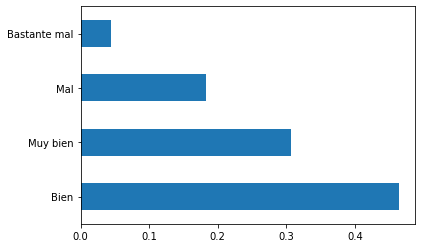

In [77]:
############### TODO: ordenar labels ##########################

labels = {"1":"Bastante mal", "2":"Mal", "3":"Bien", "4":"Muy bien"}

aux = df.copy()
aux["como_venis_llevando_la_cuarentena"] = aux["como_venis_llevando_la_cuarentena"].apply(str)

aux = normalize_dataframe_column_replace(aux, "como_venis_llevando_la_cuarentena", labels)
gph = aux["como_venis_llevando_la_cuarentena"].value_counts(normalize=True)
gph.plot.barh();

charts["como_venis_llevando"] = to_rechart(gph)

In [78]:
charts

{'total_surveyed': 6095,
 'total_analyzed_surveyed': 5715,
 'como_venis_llevando': {'data': [{'name': 'Bien',
    'value': 0.46491688538932635},
   {'name': 'Muy bien', 'value': 0.30743657042869643},
   {'name': 'Mal', 'value': 0.18337707786526683},
   {'name': 'Bastante mal', 'value': 0.04426946631671041}]}}

#### 2.1.2. ¿Qué tipo de cuarentena estás haciendo?

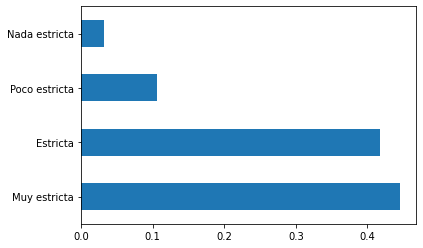

In [73]:
labels = {"1":"Nada estricta", "2":"Poco estricta", "3":"Estricta", "4":"Muy estricta"}

aux = df.copy()
aux["que_tipo_de_cuarentena_estas_haciendo"] = aux["que_tipo_de_cuarentena_estas_haciendo"].apply(str)

aux = normalize_dataframe_column_replace(aux, "que_tipo_de_cuarentena_estas_haciendo", labels)
gph = aux["que_tipo_de_cuarentena_estas_haciendo"].value_counts(normalize=True)
gph.plot.barh();

### 2.2. Situación habitacional

#### 2.2.1. ¿Con cuántas personas convivís?

#### 2.2.2. ¿Con quiénes estás conviviendo?

#### 2.2.3. ¿Tenés hijos/as menores de edad?

#### 2.2.4. ¿Tenés un espacio dedidcado para el trabajo?

#### 2.2.5. ¿Tenés que compartir tu equipo de trabajo con alguien?

### 2.3. Situación laboral

#### 2.3.1. ¿Cambió tu situación laboral a raíz de la pandemia?

#### 2.3.2. ¿Qué tanto sentís que te está apoyando tu empresa en esta situación?

#### 2.3.3. ¿Cómo se vio afectada tu empresa?

#### 2.3.4. ¿Instauraron algún beneficio nuevo?